# This notebooks is based on cb_hbeta_hgamma_ratios.py
## Important relevant python packages

In [1]:
import importlib
from os import listdir
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## define relevant things
### note: need to pip install ppxf

In [2]:
filepath = 'galaxies_fits/spec-0761-54524-0409.fits'
galfolpath = 'galaxies_fits_DR15/'
fitsfiles = [f for f in listdir(galfolpath)]
cbfits = importlib.import_module('cb_galaxy_fits_sfr_analysis_tools')
ppcbfits = importlib.import_module('cb_ppxf_tools')

## Plotting function

In [3]:
def plot_area_of_interestAAS(plot_data,plottext,filepath,ppxf_data=False):

    #Get relevant stuff for generating a figure
    em_lowlim,em_maxlim,cont_low,cont_high,flux,lam,cont_const = plot_data[0],plot_data[1],plot_data[2],plot_data[3],\
                                                                 plot_data[4],plot_data[5],plot_data[6]
    lam_c = lam[cont_low:cont_high+1]
    flux_c = flux[cont_low:cont_high+1]
    plot_fulln = cbfits.get_plot_title(filepath)
    plot_title = plot_fulln[21:26]
    typetag = plottext[0]
    fluxvalue = plottext[1]

    fluxdata = cont_const[2]

    #Generating that figure
    #with PdfPages('Emissionline.pdf') as pdf:
    fig = plt.figure()
    fig.suptitle(plot_title + ' - ' + typetag + ' - ' + fluxvalue)

    ax = fig.add_subplot(1, 2, 1)
    ax.axvspan(lam[em_lowlim], lam[em_maxlim], alpha=0.5, color='cyan', label='Area of Emission')
    # ax.axvspan(lam[em_lowlim], lam[em_maxlim], alpha=0.2, color='red')
    ax.plot(lam_c, flux_c, color='black', linewidth=0.3)

    if ppxf_data:
        galfit_c = cont_const[0][cont_low:cont_high+1]
        gasfit_c = cont_const[1][cont_low:cont_high+1]
        tallstarfit = (galfit_c - gasfit_c) * np.median(fluxdata)
        ax.plot(lam_c, galfit_c, color='orange', linewidth=0.3)
        ax.plot(lam_c, (gasfit_c*np.median(fluxdata))+tallstarfit[0], color='red', linewidth=0.3)
        ax.plot(lam_c, galfit_c-gasfit_c, color='blue', linewidth=0.3)
        ax.plot(lam_c, tallstarfit, color='blue', linewidth=0.3)
        ax.plot(lam_c, fluxdata[cont_low:cont_high+1], color='grey', linewidth=0.3)
    elif not ppxf_data:
        plt.axhline(y=cont_const, color='blue', label='Continuum', alpha=0.3)


    ax.set_xlabel("$\AA ngstr \ddot{o} ms$")
    ax.set_ylabel("Flux [$10^{-17}$ erg/$cm^{2}$/s/$\AA$]")
    plt.legend(loc=2)
    ax.grid(True)
    plt.savefig(plot_title + ' - ' + typetag + '.png')

## Function to get Hbeta and Hgamma fluxes

In [4]:
def get_ratios():
    columns = np.array([])
    hbfluxes = np.array([])
    hgfluxes = np.array([])
    for file in fitsfiles:
        print('\nAnalyzing: ', file, '..........')
        filepath = galfolpath + file
        hg_spread, hg_wav = cbfits.wspread(filepath, 'H_gamma', 400)
        hb_spread, hb_wav = cbfits.wspread(filepath, 'H_beta', 400)
        fits_data = ppcbfits.ppxf_example_population_gas_sdss(filepath, tie_balmer=True, limit_doublets=True) # gets [pp,wave,norm_flux,flux,flux&uncert]
        hg_flux, plot_datag = ppcbfits.pp_get_flux(hg_wav, hg_spread, fits_data)
        hb_flux, plot_datab = ppcbfits.pp_get_flux(hb_wav, hb_spread, fits_data)
        galname = cbfits.get_plot_title(filepath)
        plot_area_of_interestAAS(plot_datab, ['Hbeta', str(hb_flux)], filepath, ppxf_data=True)
        plot_area_of_interestAAS(plot_datag, ['Hgamma', str(hg_flux)], filepath, ppxf_data=True)

        hbfluxes = np.append(hbfluxes, hb_flux)
        hgfluxes = np.append(hgfluxes, hg_flux)
        columns = np.append(columns, galname)
    print('Success')
    return columns, hbfluxes, hgfluxes

## Run the get_ratios() function, organize data in pandas, send to csv


Analyzing:  spec-0913-52433-0300.fits ..........
Z -----------  0.66115844
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[OIII]5007_d']


/home/idies/miniconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:331: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfft_numpy(a, n=n, axis=axis)


 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    151878       584    -0.146     0.089
 comp.  1:    151797       588
 comp.  2:    152022       584
Gas Reddening E(B-V): -0.000
chi2/DOF: 233.2
method = capfit; Jac calls: 11; Func calls: 223; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  18 / 154
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1        Balmer      24.93      0.17  151797   588
Comp:  2  [OII]3726_d1      12.05       0.9  152022   584
Comp:  2  [OII]3726_d2          0       0.9  152022   584
Comp:  2  [OIII]5007_d      4.321      0.11  152022   584
---------------------------------------------------------
Desired Delta Chi^2: 62.26
Current Delta Chi^2: 4.5e+05
Elapsed time in PPXF: 36.67 s
Weighted <logAge> [yr]: 9.56
Weighted <[M/H]>: -0.139
M/L_r: 1.144
----WSPREAD  [9.62295795]
--------------------WAVEL [7212

M/L_r: 0.615
----WSPREAD  [8.76955308]
--------------------WAVEL [6572.61468519]
--------------------LAM [5357.7227 5358.955  5360.191  ... 9178.679  9180.795  9182.907 ] TYPE  <class 'numpy.ndarray'>
GASFIT  [-1.50194667e-06 -1.38906555e-06 -1.19626109e-06 ...  4.38558357e-16
  1.12479701e-15  1.59046217e-15]  emlowlim  882  emmaxlim  893
----WSPREAD  [9.82189251]
--------------------WAVEL [7361.3232452]
--------------------LAM [5357.7227 5358.955  5360.191  ... 9178.679  9180.795  9182.907 ] TYPE  <class 'numpy.ndarray'>
GASFIT  [-1.50194667e-06 -1.38906555e-06 -1.19626109e-06 ...  4.38558357e-16
  1.12479701e-15  1.59046217e-15]  emlowlim  1374  emmaxlim  1386

Analyzing:  spec-1577-53495-0564.fits ..........
Z -----------  0.4491216242313385
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[OIII]5007_d' '[OI]6300_d']
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    111155       193     0.015     0.059
 comp.  1:    111097       273


/home/idies/workspace/Storage/adiamond/persistent/github/bates_galaxies_lab/hires/cb_ppxf_tools.py:72: RuntimeWarning: divide by zero encountered in true_divide
  uncert_arr = np.sqrt(1/coadd['ivar'])[mask]


Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[OIII]5007_d' '[OI]6300_d']
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    101046       228     0.023     0.091
 comp.  1:    100954       430
 comp.  2:    101113       157
Gas Reddening E(B-V): 0.048
chi2/DOF: 59.01
method = capfit; Jac calls: 8; Func calls: 164; Status: 4
linear_method = nnls; Nonzero Templates (>0.1%):  35 / 155
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1        Balmer      16.01      0.13  100954   430
Comp:  2  [OII]3726_d1          0      0.17  101113   157
Comp:  2  [OII]3726_d2      4.803      0.17  101113   157
Comp:  2  [OIII]5007_d       2.26     0.062  101113   157
Comp:  2    [OI]6300_d    0.01418     0.061  101113   157
---------------------------------------------------------
Desired Delta Chi^2: 73.18
Current Delta Ch

/home/idies/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



Analyzing:  spec-0518-52282-0605.fits ..........
Z -----------  0.4510496258735657
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[OIII]5007_d' '[OI]6300_d']
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    111514       152     0.026     0.048
 comp.  1:    111564       182
 comp.  2:    111710       279
Gas Reddening E(B-V): 0.000
chi2/DOF: 129.1
method = capfit; Jac calls: 5; Func calls: 105; Status: 3
linear_method = nnls; Nonzero Templates (>0.1%):  25 / 155
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component   name       flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1        Balmer      9.062       0.1  111564   182
Comp:  2  [OII]3726_d1      1.812      0.33  111710   279
Comp:  2  [OII]3726_d2          0      0.33  111710   279
Comp:  2  [OIII]5007_d      1.116     0.079  111710   279
Comp:  2    [OI]6300_d          0     0.063  111710   279
-----------------

M/L_r: 1.819
----WSPREAD  [10.14576873]
--------------------WAVEL [7604.0623673]
--------------------LAM [6198.411  6199.8403 6201.2666 ... 9208.319  9210.443  9212.562 ] TYPE  <class 'numpy.ndarray'>
GASFIT  [1.29620831e-09 1.52805930e-09 1.80048418e-09 ... 2.45885299e-15
 2.18154523e-15 2.19328256e-15]  emlowlim  882  emmaxlim  893
----WSPREAD  [11.36325295]
--------------------WAVEL [8516.54383277]
--------------------LAM [6198.411  6199.8403 6201.2666 ... 9208.319  9210.443  9212.562 ] TYPE  <class 'numpy.ndarray'>
GASFIT  [1.29620831e-09 1.52805930e-09 1.80048418e-09 ... 2.45885299e-15
 2.18154523e-15 2.19328256e-15]  emlowlim  1374  emmaxlim  1386

Analyzing:  spec-0761-54524-0409.fits ..........
Z -----------  0.6032893061637878
Emission lines included in gas templates:
['Balmer' '[OII]3726_d1' '[OII]3726_d2' '[OIII]5007_d']
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:    141465       249     0.023     0.063
 comp.  1:    141417       200
 comp.  2:    141460   

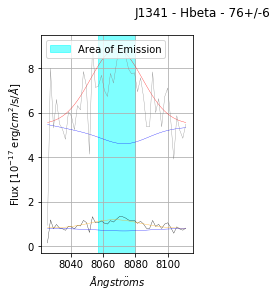

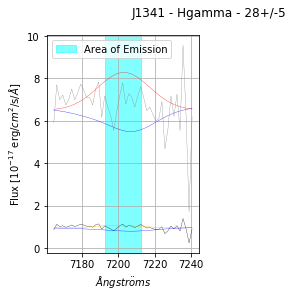

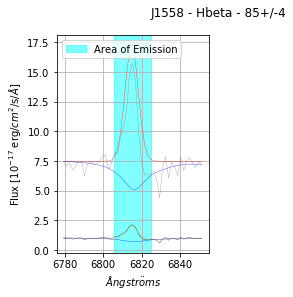

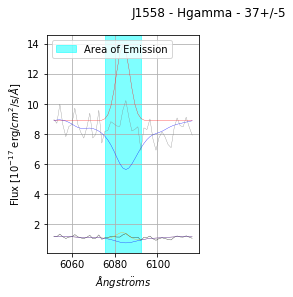

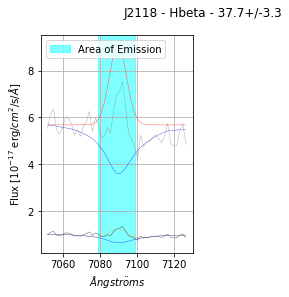

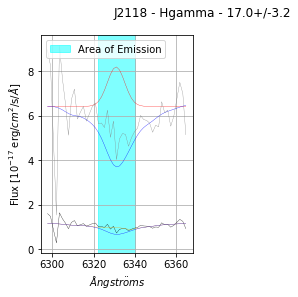

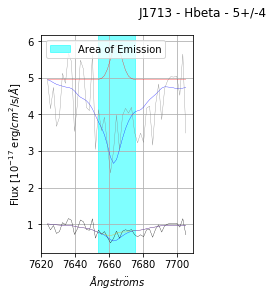

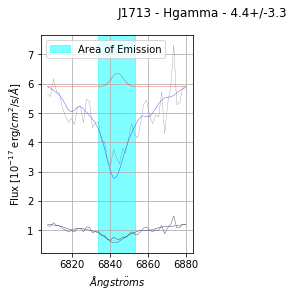

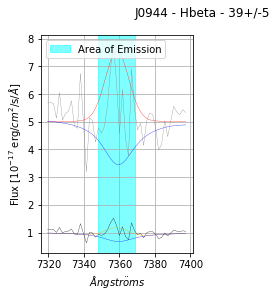

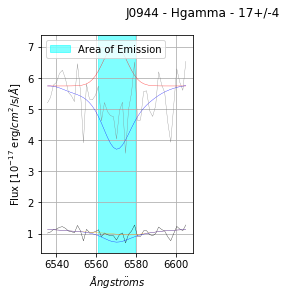

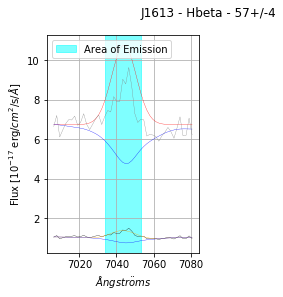

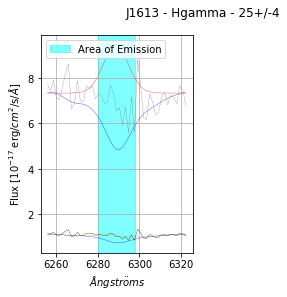

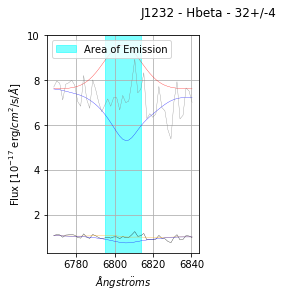

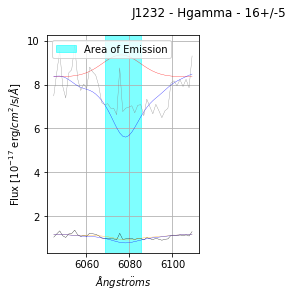

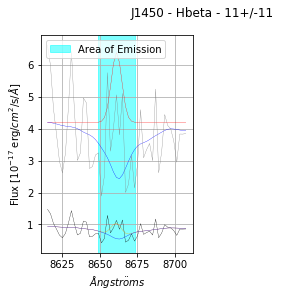

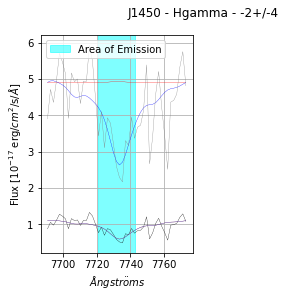

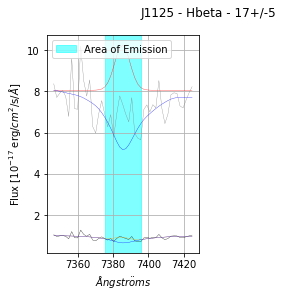

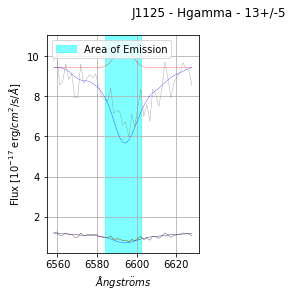

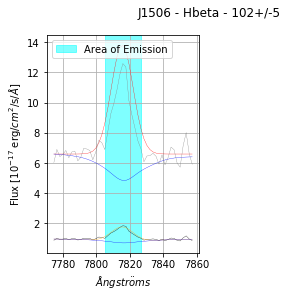

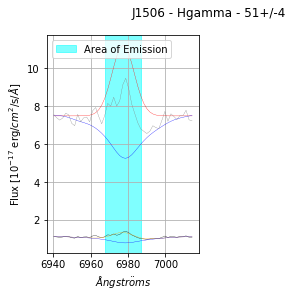

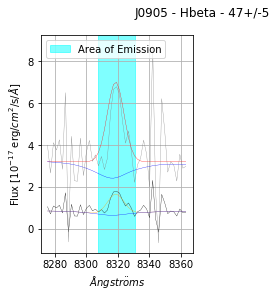

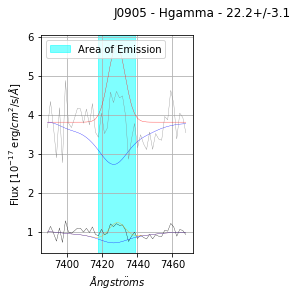

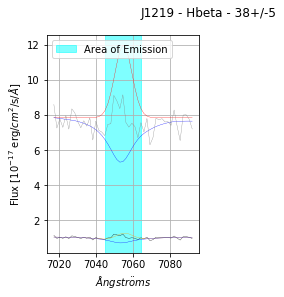

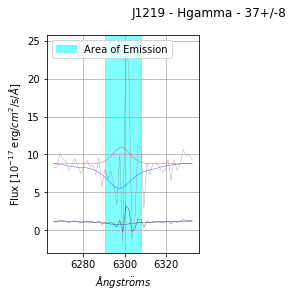

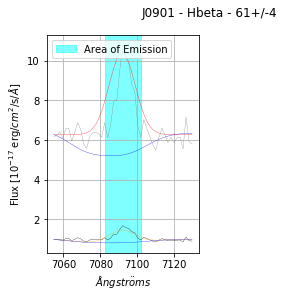

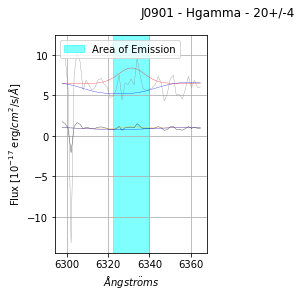

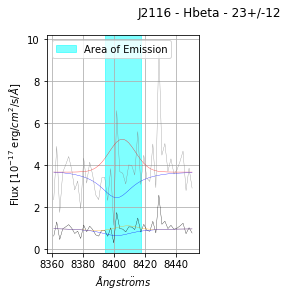

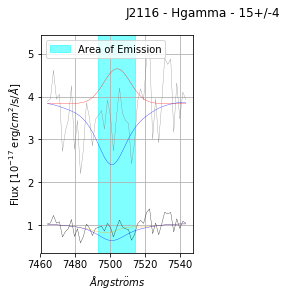

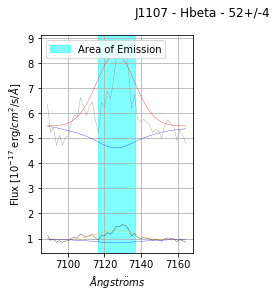

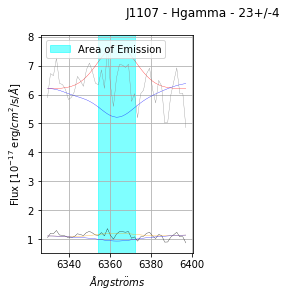

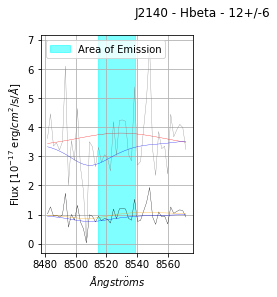

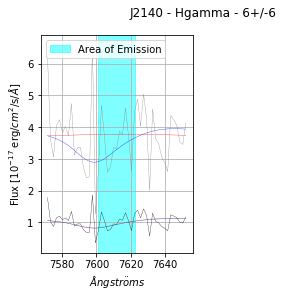

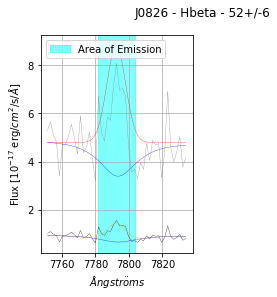

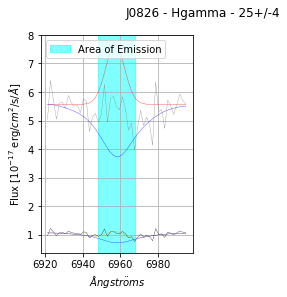

In [5]:
index, hbfluxes, hgfluxes = get_ratios()
ratios = hgfluxes/hbfluxes
data = [[hbfluxes[i], hgfluxes[i], ratios[i]] for i in range(0, len(ratios))]
columns = ['H_beta Flux', 'H_gamma Flux', 'Hg/Hb Ratio']
df = pd.DataFrame(data, index, columns)
df.to_csv('Hb-Hg-ratios.csv')
print('-----------Finished-----------!')